# Load and split the data

In [1]:
# Main imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Model selections
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Generate new values
from imblearn.over_sampling import SMOTE

# Create Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as IMBPipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.inspection import permutation_importance

# Metrics
from sklearn.metrics import roc_auc_score

In [2]:
from utils import clean_and_prepare_data
from utils import get_preprocessing_transformer

In [3]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X, y = clean_and_prepare_data(data)

In [4]:
data.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1332,Male,No,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.10,False
1720,Female,Yes,No,No,2,Yes,No,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),83.80,163.70,False
6182,Male,No,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),88.70,6501.35,False
4470,Male,No,No,No,7,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.65,322.50,False
4007,Male,No,Yes,No,55,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.70,1443.65,False


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, shuffle=True, random_state=1, stratify=y)

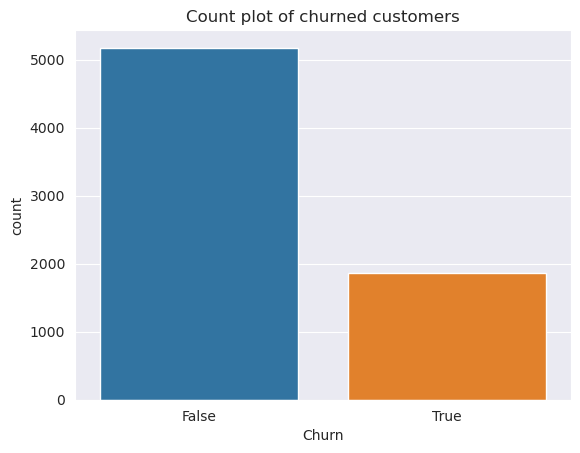

In [6]:
plt.title("Count plot of churned customers")
sns.countplot(x=data['Churn']);

We can see, that our data is unbalanced. To handle this we'll use SMOTE method to make our data balanced

# Preprocessing

Steps:
1. Impute missing values
2. OneHot encode categorical values

In [7]:
preprocessing = get_preprocessing_transformer()
preprocessing.fit(X_train, y_train)
features = pd.Series(preprocessing.get_feature_names_out())

In [8]:
pipe = Pipeline([
    # Preprocess features
    ('preprocessing', preprocessing)
])

### Extract transformed and scaled features from the pipeline

In [9]:
pipe.fit(X_train, y_train)
features = pd.Series(pipe.get_feature_names_out())
features

0                           numerical_transform__tenure
1                   numerical_transform__MonthlyCharges
2                     numerical_transform__TotalCharges
3                  categorical_transform__gender_Female
4                    categorical_transform__gender_Male
5               categorical_transform__SeniorCitizen_No
6              categorical_transform__SeniorCitizen_Yes
7                     categorical_transform__Partner_No
8                    categorical_transform__Partner_Yes
9                  categorical_transform__Dependents_No
10                categorical_transform__Dependents_Yes
11               categorical_transform__PhoneService_No
12              categorical_transform__PhoneService_Yes
13              categorical_transform__MultipleLines_No
14    categorical_transform__MultipleLines_No phone ...
15             categorical_transform__MultipleLines_Yes
16           categorical_transform__InternetService_DSL
17    categorical_transform__InternetService_Fib

### Define models

In [10]:
logreg = LogisticRegression(warm_start=True, max_iter=1000)
booster = HistGradientBoostingClassifier()
naive = GaussianNB()

voter = VotingClassifier(estimators=[('logreg', logreg),
                                     ('booster', booster),
                                     ('naive', naive)],
                        voting='soft', 
                        n_jobs=-1)

stacker = StackingClassifier(estimators=[('logreg', logreg),
                                     ('booster', booster),
                                     ('naive', naive)],
                        final_estimator=LogisticRegression(), 
                        n_jobs=-1)

# Build pipeline using IMBlearn

In [22]:
imbpipe = IMBPipeline([
    # 1. Preprocess features
    ('preprocessing', preprocessing),
    # 2. Generate new data
    ('smote', SMOTE()),
    # 3. Use voter model
    ('ensemble', voter)
])
# imbpipe = IMBPipeline([
#     # 1. Preprocess features
#     ('preprocessing', preprocessing),
#     # 2. Generate new data
#     ('smote', SMOTE()),
#     # 3. Use voter model
#     ('ensemble', stacker)
# ])

In [23]:
imbpipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f17998a35b0>),
                                                 ('categorical_transform',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f17998a3670>)])),
                ('smote', SMOTE()),
                ('ensemble',
                 VotingClassifier(estimators=[('logreg',
                                               LogisticRegression(max_iter=1000,
                                                                  warm_start=True)),
                                              ('booster',
                                               HistGradientBoostingClassifier()),
                                              ('naive', GaussianNB())],
                                  n_jobs=-1, voting='soft'))])

# Hyperparameter tuning

In [24]:
params = {
    'ensemble__logreg__solver': ['newton-cg', 'lbfgs'],
    'ensemble__logreg__penalty': ['l1', 'l2'],
    'ensemble__logreg__C': [1e-5, 1e-3, 10],
    'ensemble__booster__learning_rate': [1e-5, 1e-3, 1e-1],
    'ensemble__booster__max_iter': [100, 200],
    'ensemble__booster__max_depth': [5, 10],
    'ensemble__booster__l2_regularization': [0, 1]
}

rep_folds = RepeatedStratifiedKFold(random_state=42)

random_search_model = RandomizedSearchCV(
    estimator=imbpipe,
    param_distributions=params,
    scoring='roc_auc',
    cv=rep_folds,
    n_jobs=-1,
    verbose=1
)

random_search_model.fit(X_train, y_train)

print("[INFO] Best Score: ", random_search_model.best_score_)
print("[INFO] Best Parameters: ", random_search_model.best_params_)
print("[INFO] ROC-AUC score: ", roc_auc_score(y_val, random_search_model.predict(X_val)))

Fitting 50 folds for each of 10 candidates, totalling 500 fits


/home/statixx/anaconda3/envs/stats/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/statixx/anaconda3/envs/stats/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/statixx/anaconda3/envs/stats/lib/python3.9/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/statixx/anaconda3/envs/stats/lib/python3.9/site-packages/sklearn/ensemble/_votin

[INFO] Best Score:  0.8458827263148747
[INFO] Best Parameters:  {'ensemble__logreg__solver': 'newton-cg', 'ensemble__logreg__penalty': 'l2', 'ensemble__logreg__C': 10, 'ensemble__booster__max_iter': 100, 'ensemble__booster__max_depth': 5, 'ensemble__booster__learning_rate': 0.1, 'ensemble__booster__l2_regularization': 0}
[INFO] ROC-AUC score:  0.7440311038776514


In [25]:
def plot_feature_importance(results, features):
    fig, ax = plt.subplots()
    indices = results['importances_mean'].argsort()
    
    plt.barh(range(len(indices)),
        results['importances_mean'][indices],
        xerr=results['importances_std'][indices]
        )

    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")

    tmp = np.array(features)
    _ = ax.set_yticklabels(tmp[indices])
    return


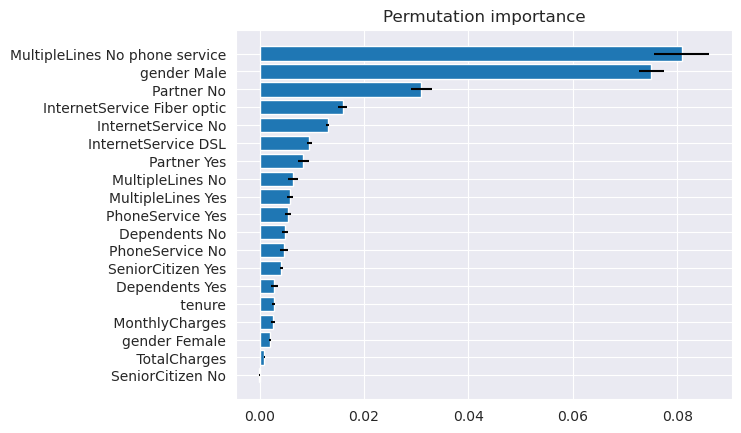

In [26]:
crop_features = [" ".join(str(feature).split("_")[-2:]) for feature in features]

importance_results = permutation_importance(random_search_model, X_train, y_train, random_state=42, n_jobs=-1)
plot_feature_importance(importance_results, crop_features)

### Metrics

In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

y_pred = random_search_model.predict(X_val)
precision = precision_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred)

print("[INFO] Precision is: ", precision)
print("[INFO] F1-Score is: ", f1score)

[INFO] Precision is:  0.4852459016393443
[INFO] F1-Score is:  0.6016260162601627


# Conclusions:

As we can see, the most important features is: MultipleLines, Gender, Partner, InternetService and PhoneService. The other features not really much influence our data. So we can conclude, that the male customer, that doesn't use phone service, who's not a partner for us and who's not using Internet service in most cases will leave the company.